# Selecting features
When selecting the right features, there are some rules of thumb one can take into account. For example if one wants to segment objects very precisely, small radius / sigma values should be used. If a rough outline is enough, or if single individual pixels on borders of objects should be eliminated, it makes sense to use larger radius and sigma values. However, this topic can also be approached using statistics.

In [1]:
from skimage.io import imread, imsave
import pyclesperanto_prototype as cle
import numpy as np
import apoc
import matplotlib.pyplot as plt
import pandas as pd

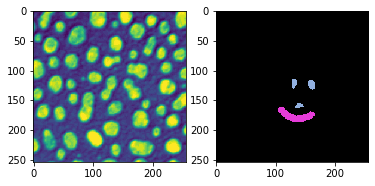

In [2]:
image = imread('../../data/blobs.tif')

manual_annotation = imread('../../data/blobs_annotations.tif')

fig, axs = plt.subplots(1,2)

cle.imshow(image, plot=axs[0])
cle.imshow(manual_annotation, labels=True, plot=axs[1])

## Training - with too many features
We now train a object segmenter and provide many features. We also need to provide parameters to configure deep decision trees and many trees. This is necessary so that the next steps, deriving statistics, has enough statistical power.
Afterwards, we take a look at the result for a quick sanity check.

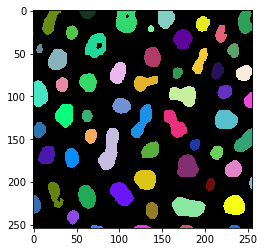

In [3]:
# define features
features = apoc.PredefinedFeatureSet.small_dog_log.value + " " + \
           apoc.PredefinedFeatureSet.medium_dog_log.value + " " + \
           apoc.PredefinedFeatureSet.large_dog_log.value

# this is where the model will be saved
cl_filename = '../../data/blobs_object_segmenter2.cl'

apoc.erase_classifier(cl_filename)
classifier = apoc.ObjectSegmenter(opencl_filename=cl_filename, 
                           positive_class_identifier=2, 
                           max_depth=5,
                           num_ensembles=1000)
classifier.train(features, manual_annotation, image)

segmentation_result = classifier.predict(features=features, image=image)
cle.imshow(segmentation_result, labels=True)

## Classifier statistics
After training, we can print out some statistics from the classifier. It gives us a table of used features and how important the features were for making the pixel classification decision.

In [4]:
shares, counts = classifier.statistics()

def colorize(styler):
    styler.background_gradient(axis=None, cmap="rainbow")
    return styler

df = pd.DataFrame(shares).T
df.style.pipe(colorize)

,0,1,2,3,4
original,0.138000,0.046423,0.042312,0.037281,0.062112
gaussian_blur=1,0.228000,0.092846,0.074303,0.105263,0.055901
difference_of_gaussian=1,0.000000,0.108828,0.095975,0.074561,0.086957
laplace_box_of_gaussian_blur=1,0.000000,0.105784,0.089783,0.081140,0.099379
gaussian_blur=5,0.096000,0.064688,0.118679,0.096491,0.130435
difference_of_gaussian=5,0.254000,0.182648,0.112487,0.120614,0.118012
laplace_box_of_gaussian_blur=5,0.209000,0.194064,0.121775,0.118421,0.124224
gaussian_blur=25,0.004000,0.061644,0.113519,0.127193,0.080745
difference_of_gaussian=25,0.032000,0.072298,0.122807,0.127193,0.130435
laplace_box_of_gaussian_blur=25,0.039000,0.070776,0.108359,0.111842,0.111801


In this visualization you can see that the features `gaussian_blur=1`, `difference_of_gaussian=5` and `laplace_box_of_gaussian_blur=5` make about 65% of the decision. On the first level (level `0`). If these three features are crucial, we can train another classifier that only takes these features into account. Furthermore, we see that the share the features are used on the higher three depth levels is more uniformly distributed. These levels may not make a big difference when classifying pixels. The next classifier we train, we can train with lower `max_depth`.

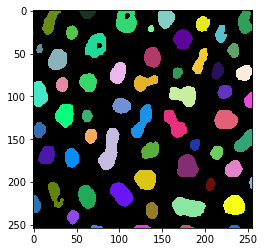

In [5]:
# define features
features = "gaussian_blur=1 difference_of_gaussian=5 laplace_box_of_gaussian_blur=5"

# this is where the model will be saved
cl_filename = '../../data/blobs_object_segmenter3.cl'

apoc.erase_classifier(cl_filename)
classifier = apoc.ObjectSegmenter(opencl_filename=cl_filename, 
                           positive_class_identifier=2, 
                           max_depth=3,
                           num_ensembles=1000)
classifier.train(features, manual_annotation, image)

segmentation_result = classifier.predict(features=features, image=image)
cle.imshow(segmentation_result, labels=True)

The new classifier still produces a very similar result. It takes less features into account, which makes it faster, but potentially also less robust against differences between images and imaging conditions. We just take another look at the classifier statistics:

In [6]:
shares, counts = classifier.statistics()
df = pd.DataFrame(shares).T
df.style.pipe(colorize)

,0,1,2
gaussian_blur=1,0.331000,0.349194,0.344620
difference_of_gaussian=5,0.356000,0.329839,0.337096
laplace_box_of_gaussian_blur=5,0.313000,0.320968,0.318284


For demonstration purposes, we will now train another classifier with very similar features.

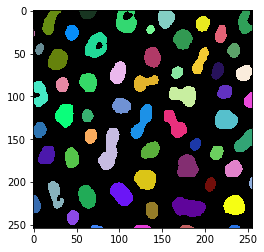

In [7]:
# define features
features = "gaussian_blur=1 difference_of_gaussian=2 difference_of_gaussian=3 difference_of_gaussian=4 difference_of_gaussian=5 difference_of_gaussian=6 laplace_box_of_gaussian_blur=5"

# this is where the model will be saved
cl_filename = '../../data/blobs_object_segmenter3.cl'

apoc.erase_classifier(cl_filename)
classifier = apoc.ObjectSegmenter(opencl_filename=cl_filename, 
                           positive_class_identifier=2, 
                           max_depth=3,
                           num_ensembles=1000)
classifier.train(features, manual_annotation, image)

segmentation_result = classifier.predict(features=features, image=image)
cle.imshow(segmentation_result, labels=True)

Again, the segmentation result looks very similar, but the classifier statistic is different.

In [8]:
shares, counts = classifier.statistics()
df = pd.DataFrame(shares).T
df.style.pipe(colorize)

,0,1,2
gaussian_blur=1,0.200000,0.093750,0.162829
difference_of_gaussian=2,0.000000,0.120888,0.148026
difference_of_gaussian=3,0.053000,0.064967,0.125000
difference_of_gaussian=4,0.236000,0.162829,0.097039
difference_of_gaussian=5,0.178000,0.222862,0.125822
difference_of_gaussian=6,0.134000,0.120066,0.194901
laplace_box_of_gaussian_blur=5,0.199000,0.214638,0.146382


In that way one can also fine-tune the radius and sigma parameters one needs to use for the specified features. 

The hints given here in this section are no solid rules for selecting the right features. The provided tools may help though for looking a bit behind the features and for measuring the influence provided feature lists and parameters have.